In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from dataloader import read_bci_data

In [2]:
''' 
Get device (if GPU is available, use GPU) 
'''
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
"""
Sets parameters
"""
device = get_device()
lR = 0.001
BATCH_SIZE = 64
n_epoch = 501
train_data, train_label, test_data, test_label = read_bci_data()
activation_list = ['ReLU', 'LeakyReLU', 'ELU']

train_data_set = TensorDataset(torch.FloatTensor(train_data), torch.LongTensor(train_label)) 
test_data_set = TensorDataset(torch.FloatTensor(test_data), torch.LongTensor(test_label))

train_data_loader = DataLoader(
    dataset = train_data_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_data_set,
    batch_size = BATCH_SIZE,
    shuffle = False
)

ReLU_train_acc = []
ReLU_test_acc = []
LeakyReLU_train_acc = []
LeakyReLU_test_acc = []
ELU_train_acc = []
ELU_test_acc = []
total_data = len(train_data)
correct_training = 0
correct_testing = 0
acc_test = 0
max_ReLU_acc = 0
max_LeakyReLU_acc = 0
max_ELU_acc = 0

In [4]:
class EEGNetwork(nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        self.activations = nn.ModuleDict([['ReLU', nn.ReLU()], ['LeakyReLU', nn.LeakyReLU()], ['ELU', nn.ELU(alpha = 1.0)]])
        
        self.first_conv = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = (1, 51),
                stride = (1, 1),
                padding = (0, 25),
                bias = False
            ),
            
            nn.BatchNorm2d(16)
        )
        
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = (2, 1),
                stride = (1, 1),
                groups = 16,
                bias = False
            ),
    
            nn.BatchNorm2d(32), 
            self.activations[activation_function],
            nn.AvgPool2d(kernel_size = (1, 4), stride = (1, 4), padding = 0),
            nn.Dropout(p = 0.25)
        )
        
        self.separable_conv = nn.Sequential(
           nn.Conv2d(
                in_channels = 32,
                out_channels = 32,
                kernel_size = (1, 15),
                stride = (1, 1),
                padding = (0, 7),
                bias = False
            ),
            
            nn.BatchNorm2d(32), 
            self.activations[activation_function],
            nn.AvgPool2d(kernel_size = (1, 8), stride = (1, 8), padding = 0),
            nn.Dropout(p = 0.25) 
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736, 2, bias = True)
        )
 
    def forward(self, x):
        first_conv_result = self.first_conv(x)
        depthwise_conv_result = self.depthwise_conv(first_conv_result)
        separable_conv_result = self.separable_conv(depthwise_conv_result)
        return self.classify(separable_conv_result)
        

In [5]:
def train(batch_size = BATCH_SIZE):
    criterion = nn.CrossEntropyLoss()
    
    for activation_function in ['ReLU', 'LeakyReLU', 'ELU']:
        model = EEGNetwork(activation_function)
        model.to(device)
        criterion.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lR)
        
        for epoch in range(n_epoch):
            global correct_training
            correct_training = 0
            global correct_testing
            correct_testing = 0
            model.train()
            for _, (training_data, training_label) in enumerate(train_data_loader):
                training_data = training_data.to(device)
                training_label = training_label.to(device)
                training_output = model(training_data)
                training_loss = criterion(training_output, training_label)
                optimizer.zero_grad()
                training_loss.backward()
                optimizer.step()
                predict_val = torch.max(training_output, 1)[1]
                correct_training += (predict_val == training_label).sum()

            acc_train = (correct_training / total_data) * 100

            if activation_function == 'ReLU':
                ReLU_train_acc.append(acc_train.item())
                
            elif activation_function == 'LeakyReLU':
                LeakyReLU_train_acc.append(acc_train.item())
            else:
                ELU_train_acc.append(acc_train.item())
            test(model, activation_function)
            if epoch % (n_epoch // 10) == 0:
                print(f'Epoch:{epoch:5}, acc_train:{acc_train:.2f}%')
                global acc_test
                print(f'Epoch:{epoch:5}, acc_test:{acc_test:.2f}%')

In [6]:
def test(model, activation_function,):
    model.eval()
    with torch.no_grad():
        for _, (testing_data, testing_label) in enumerate(test_data_loader):
            testing_data = testing_data.to(device)
            testing_label = testing_label.to(device)
            testing_output = model(testing_data)

            predict_val = torch.max(testing_output, 1)[1]
            global correct_testing
            correct_testing += (predict_val == testing_label).sum()

        global acc_test
        acc_test = correct_testing / total_data * 100

    if activation_function == 'ReLU':
        ReLU_test_acc.append(acc_test.item())
        global max_ReLU_acc
        max_ReLU_acc = max(max_ReLU_acc, acc_test)
    elif activation_function == 'LeakyReLU':
        LeakyReLU_test_acc.append(acc_test.item())
        global max_LeakyReLU_acc
        max_LeakyReLU_acc = max(max_LeakyReLU_acc, acc_test)
    else:
        ELU_test_acc.append(acc_test.item())
        global max_ELU_acc
        max_ELU_acc = max(max_ELU_acc, acc_test)

In [7]:
model = train(BATCH_SIZE)

Epoch:    0, acc_train:63.70%
Epoch:    0, acc_test:69.44%
Epoch:   50, acc_train:94.17%
Epoch:   50, acc_test:85.19%
Epoch:  100, acc_train:97.96%
Epoch:  100, acc_test:85.00%
Epoch:  150, acc_train:97.96%
Epoch:  150, acc_test:85.83%
Epoch:  200, acc_train:98.80%
Epoch:  200, acc_test:86.11%
Epoch:  250, acc_train:98.52%
Epoch:  250, acc_test:85.37%
Epoch:  300, acc_train:98.70%
Epoch:  300, acc_test:85.83%
Epoch:  350, acc_train:99.26%
Epoch:  350, acc_test:85.37%
Epoch:  400, acc_train:98.70%
Epoch:  400, acc_test:85.28%
Epoch:  450, acc_train:99.44%
Epoch:  450, acc_test:84.44%
Epoch:  500, acc_train:99.44%
Epoch:  500, acc_test:85.09%
Epoch:    0, acc_train:61.85%
Epoch:    0, acc_test:68.98%
Epoch:   50, acc_train:93.24%
Epoch:   50, acc_test:82.69%
Epoch:  100, acc_train:96.39%
Epoch:  100, acc_test:84.17%
Epoch:  150, acc_train:97.22%
Epoch:  150, acc_test:83.98%
Epoch:  200, acc_train:98.61%
Epoch:  200, acc_test:84.44%
Epoch:  250, acc_train:98.61%
Epoch:  250, acc_test:84.3

In [8]:
def result_plot(ReLU_train_acc, ReLU_test_acc, LeakyReLU_train_acc, LeakyReLU_test_acc, ELU_train_acc, ELU_test_acc):
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.title('Activation function comparision(EEGNET)')
    plt.plot(ReLU_train_acc, label = 'ReLU_train_acc', color = 'y')
    plt.plot(ReLU_test_acc, label = 'ReLU_test_acc', color = 'b')
    plt.plot(LeakyReLU_train_acc, label = 'LeakyReLU_train_acc', color = 'g')
    plt.plot(LeakyReLU_test_acc, label = 'LeakyReLU_test_acc', color = 'r')
    plt.plot(ELU_train_acc, label = 'ELU_train_acc', color = 'c')
    plt.plot(ELU_test_acc, label = 'ELU_test_acc', color = 'm')
    plt.legend()
    plt.show()

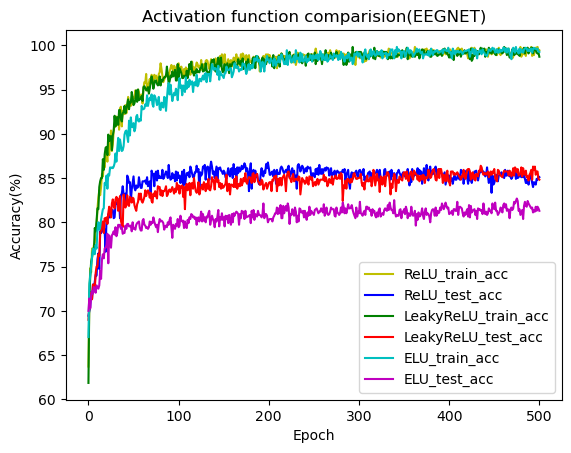

In [9]:
result_plot(ReLU_train_acc, ReLU_test_acc, LeakyReLU_train_acc, LeakyReLU_test_acc, ELU_train_acc, ELU_test_acc)

In [10]:
print(f'max_ReLU_acc: {max_ReLU_acc:.2f}%, max_LeakyReLU_acc: {max_LeakyReLU_acc:.2f}%, max_ELU_acc: {max_ELU_acc:.2f}%')

max_ReLU_acc: 86.85%, max_LeakyReLU_acc: 86.39%, max_ELU_acc: 82.69%
